<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2023/06 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Reproducibility of neural networks training with TensorFlow <a name="top"></a>

## [1 $-$ Import Python modules](#1)
## [2 $-$ Reproducibility of pseudo-random generators](#2)
## [3 $-$ A simple example with the MNIST hand-written database](#3)
## [4 $-$ Build the neural network](#4)
## [5 $-$ Reproducibility tests](#5)


<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

## 1 $-$ Import Python modules <a name="1"></a>

The **keras** module which allows high level manipulation of **tensorflow** objects is integrated in tensorflow2. <br>
The **tf.keras** module documentation to consult for this lab is here: https://www.tensorflow.org/api_docs/python/tf/keras.

In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

from utils.tools import plot_loss_accuracy

Python    : 3.12.3
tensorflow: 2.16.2 incluant keras 3.8.0
numpy     : 1.26.4


In [52]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

# 2 $-$ Reproducibility of pseudo-random generators <a name="2"></a>

The weights of a neural network are initialized by __random values__ : when pseudo-random generators are invoked several times in succession, different random sequence are created at each invocation. For example with `numpy.random.rand`:

In [3]:
import numpy as np
for _ in range(5):
    print(np.random.rand(6))

[0.22186013 0.19942758 0.80545776 0.29116312 0.98607387 0.02551105]
[0.18804424 0.30243908 0.85251383 0.19305603 0.35149412 0.52452177]
[0.80919788 0.05160724 0.87613623 0.95192696 0.37892436 0.89621563]
[0.93982111 0.5631558  0.19541243 0.64573042 0.52270372 0.71052721]
[0.64633228 0.60132957 0.24165095 0.81144974 0.27470305 0.81523501]


<h3 style="color:brown">Point of interest</h3>

<span style="color:brown">This behavior can be very inappropriate when studying the performance of a trained network as a function of meta-parameters:<br>every time you run the training of the neural network (runing the cell or the notebook) with different values of the meta-parameters, you get a different initial state of the network, leading to a different training network...
</spawn>

### The seed of random generators

The technical solution to get a reproducible random sequence from a (pseudo) random generator is to set the __seed__ of the generator.<br>

The following cells illustrate the mechanism:

In [4]:
for _ in range(5):
    np.random.seed(1234)
    print(np.random.rand(5))

[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]


<h3 style="color:brown">Point of interest</h3>

<span style="color:brown">Setting the __seed__ ensure that the random sequence is the same even on other computers (Windows, Mac, Linux...).<br>
    The figure bellow comes from a Windows10 machine :
</spawn>
![img/seed_1234_w10.png](img/seed_1234_w10.png)

Of course if you change the seed you get a different random sequence:

In [5]:
for _ in range(5):
    np.random.seed(2345)
    print(np.random.rand(5))

[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]


## 3 $-$ Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [6]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [7]:
print("im_train.shape :", im_train.shape, ", dtype:", im_train.dtype,)
print("lab_train.shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("im_valid.shape  :", im_valid.shape,  ", dtype:", im_valid.dtype,)
print("lab_valid.shape :", lab_valid.shape,  ", dtype:", lab_valid.dtype)

im_train.shape : (60000, 28, 28) , dtype: uint8
lab_train.shape: (60000,) , dtype: uint8
im_valid.shape  : (10000, 28, 28) , dtype: uint8
lab_valid.shape : (10000,) , dtype: uint8


### Visualization of images and labels:

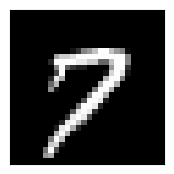

The image should show the digit 7...


In [8]:
plt.figure(figsize=(2,2))
plt.imshow(im_train[599], cmap='gray')
plt.xticks([]); plt.yticks([])
plt.show()

print(f"The image should show the digit {lab_train[599]}...")

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images:

In [9]:
from utils.tools import plot_images
help(plot_images)

Help on function plot_images in module utils.tools:

plot_images(image_array: numpy.ndarray, R: int, C: int, r: int = 0, figsize: tuple = None, reverse: bool = False)
    Plot the images from image_array on a R x C grid, starting at image rank r.
    Arguments:
       image_array: an array of images
       R: the number of rows
       C: the number of columns
       r: the starting rank in the array image_array (default: 0)
       figsize: the sise of the display (default: (C//2+1, R//2+1))
       reverse: wether to reverse video the image or not (default: False)



Let's display the training images in a 4 x 6 grid beginning with the 600th image:

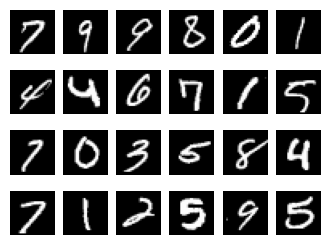

In [10]:
plot_images(im_train, 4, 6, 599)

#### Define important parameters

To avoid "hard writing" the **number of images**, the **dimension** of the images and the **number of classes** these parameters are retrieved from the dataset:
- the `shape` attribute of `im_train` and `im_valid` contains the number of training and validation images,
- the `size` attribute of the any image gives the number of pixels (784),<br>
- the transformation of the `lab_train` array into a Python `set` gives the set of labels to recognize, whose size is the number of classes.

In [21]:
nb_im_train = im_train.shape[0]    # number of training images
nb_im_valid = im_valid.shape[0]    # number of validation images
nb_pixel    = im_train[0].size     # number of elements (pixels) of the dataset images
nb_class    = len(set(lab_train))  # number of classes to classify (the ten digits from 0 to 9)

Checking:

In [22]:
print(f"{nb_im_train} traing images and {nb_im_valid} test images")
print(f"{nb_pixel} pixels in each image")
print(f"{nb_class} classes to recognize (the digits from 0 to 9)")

60000 traing images and 10000 test images
784 pixels in each image
10 classes to recognize (the digits from 0 to 9)


## 3 - Pre-process MNIST images and labels

Two treatments are applied to the data from the MNIST database:
- __on images__: transform the matrices of  28$\,\times\,$28 pixels (`uint8`integers) into **normalized** vectors $(V_i)_{i=0..783}$ of 784 real values $V_i$ with $ 0 \leqslant V_i \leqslant 1$;
- __on labels__: transform scalar numbers into *one-hot* vectors.

### Transform images into normalized vectors

We define `x_train` and `x_valid` containing the data of the arrays `im_train` and `im_valid` *flattened* as normalized vectors (values between 0 and 1):

In [13]:
x_train = im_train.reshape(nb_im_train, nb_pixel)/im_train.max()
x_valid = im_valid.reshape(nb_im_valid, nb_pixel)/im_valid.max()

Check the dimensions of the `x_train` and `x_valid` arrays as well as their *min* and *max* values:

In [14]:
print(f"min,max of x_train: ({x_train.min():f}, {x_train.max():f})")
print(f"min,max of x_train: ({x_valid.min():f}, {x_valid.max():f})")

min,max of x_train: (0.000000, 1.000000)
min,max of x_train: (0.000000, 1.000000)


### *one-hot* encoding of labels:

We use the **keras** `to_categorical` function (see [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)) to define the `y_train` and `y_valid` arrays containing the *hot-one* encoded version of `lab_train` and `lab_valid`:

In [15]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [16]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 4 $-$ Construction of the neural network<a name="4"></a>

 To get short computation times we build a simple dense network to classify the MNIST images. Of course, this is not the "state of the art" : convolutive NN, transformers have much more impressive scores, but we just want want short training computation time.<br><br>
We buildthis naive **dense network**:
- an **input layer** of 784 values (the pixels of the MNIST 28 $\times$ 28 images put in the form of a vector of 784 normalized `float` numbers),
- a **hidden layer** of 784 neurons using the `relu` activation function,
- an **output layer** of 10 neurons, for the classification of the 10 digits {0,1,2...9}, using the `softmax` activation function adapted to classification problems .

<p style="text-align:center; font-style:italic; font-size:12px;">
      <img src="img/Simple-DNN.png" alt="archiNetwork.png" style="width:900px;"><br>
     [image credit: JLC]

In [27]:
nb_input  = nb_pixel
nb_neuron = nb_pixel

For the sake of convenience purpose we défine functions to build the NN: 

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def build_NN_noseed(nb_input, nb_neuron, nb_class):
    # 5 keras lines to build the dense network without setting the tf seed: 
    # the neurons weight are set randomly in a non reproducible way    
    model = Sequential()
    model.add(Input(shape=(nb_input,), name='input'))            # INPUT layer
    model.add(Dense(nb_neuron, activation='relu', name='c1'))    # First hidden layer
    model.add(Dense(nb_class, activation='softmax', name='c2'))  # OUTPUT layer
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return model

def build_NN_seed(nb_input, nb_neuron, nb_class, seed):
    # 5 keras lines to build the dense network with setting the tf seed.
    
    # Deterministic tensorflow training: 
    # 1/ set the seed of the random generators involved with tensorflow:
    tf.keras.utils.set_random_seed(seed)
    # 2/ make the tf aps determinisctic 
    # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
    tf.config.experimental.enable_op_determinism() 

    model = Sequential()
    model.add(Input(shape=(nb_input,), name='input'))             # INPUT layer
    model.add(Dense(nb_neuron, activation='relu', name='c1'))     # First hidden layer
    model.add(Dense(nb_class, activation='softmax', name='c2'))   # OUTPUT layer
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return model


## 5 $-$ Reproducibility tests

Perfect reproducibility of a neural network training may be difficult to achieve with tensorflow...

### Reproducibility on one `epoch`

To highlight the question of reproducibility we begin by training the network with only __one epoch__:`n_epoch=1`.<br>

#### A/ If we don't set the tensorflow seed, the training is not reproducible:

In the cell bellow, we train the network on only 1 epoch 5 times on a row:

In [29]:
for _ in range(5):
    
    # Build a new network at each time
    model = build_NN_noseed(nb_pixel, nb_neuron, nb_class)

    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid))    

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4023 - loss: 1.8773 - val_accuracy: 0.7925 - val_loss: 0.9102
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4347 - loss: 1.8642 - val_accuracy: 0.7712 - val_loss: 0.9144
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4131 - loss: 1.9413 - val_accuracy: 0.8018 - val_loss: 0.9385
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3909 - loss: 1.8843 - val_accuracy: 0.7821 - val_loss: 0.9350
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4578 - loss: 1.8333 - val_accuracy: 0.7681 - val_loss: 0.9131


#### B/ If we just reload the network initial state, the training is not reproducible:

In [31]:
for _ in range(5):
    # reload the inital NN state at each lap:
    model.load_weights('weights/initialNN.weights.h5') 
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid))    

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4332 - loss: 1.9141 - val_accuracy: 0.7794 - val_loss: 0.9240
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4221 - loss: 1.9122 - val_accuracy: 0.8002 - val_loss: 0.9128
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4231 - loss: 1.9041 - val_accuracy: 0.7918 - val_loss: 0.9169
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4352 - loss: 1.9136 - val_accuracy: 0.7937 - val_loss: 0.9134
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4193 - loss: 1.9136 - val_accuracy: 0.7961 - val_loss: 0.9055


#### C/ If the tensorflow seed is set for the network build, the training is reproducible:

In [32]:
for _ in range(5):
    # Build a new network at each time, with a FIXED SEED:
    model = build_NN_seed(nb_pixel, nb_neuron, nb_class, 1)
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid))    

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4097 - loss: 1.9150 - val_accuracy: 0.7686 - val_loss: 0.9790
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4097 - loss: 1.9150 - val_accuracy: 0.7686 - val_loss: 0.9790
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4097 - loss: 1.9150 - val_accuracy: 0.7686 - val_loss: 0.9790
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4097 - loss: 1.9150 - val_accuracy: 0.7686 - val_loss: 0.9790
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4097 - loss: 1.9150 - val_accuracy: 0.7686 - val_loss: 0.9790


In [35]:
for _ in range(5):
    # Build a new network at each time, with a FIXED SEED:
    model = build_NN_seed(nb_pixel, nb_neuron, nb_class, 528)
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid))    

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3539 - loss: 1.9457 - val_accuracy: 0.7485 - val_loss: 1.0325
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3539 - loss: 1.9457 - val_accuracy: 0.7485 - val_loss: 1.0325
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3539 - loss: 1.9457 - val_accuracy: 0.7485 - val_loss: 1.0325
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3539 - loss: 1.9457 - val_accuracy: 0.7485 - val_loss: 1.0325
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3539 - loss: 1.9457 - val_accuracy: 0.7485 - val_loss: 1.0325


In [ ]:
val_loss_max = 0
for seed in range(5000):
    print(f'\rseed: {seed}', end='')
    # Build a new network at each time, with a FIXED SEED:
    build_NN_seed(nb_pixel, nb_neuron, nb_class, seed)
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid), verbose=0)    
    if hist.history['val_loss'][0] > val_loss_max :
        val_loss_max = hist.history['val_loss'][0]
        seed_index = seed
        print(seed_index, val_loss_max)      

0 0.9687432646751404
1 0.9790405035018921
9 0.997001588344574
28 0.9995589852333069
86 1.0052142143249512
100 1.0138779878616333
528 1.032522439956665
seed: 3828

#### D/ If we reload the network initial state, and set the seed: it's better but still not perfectly reproducible:

In [40]:
# Build a new network at each time
model = build_NN_noseed(nb_pixel, nb_neuron, nb_class)

for _ in range(10):    
    # reload the inital NN state at each lap:
    model.load_weights('weights/initialNN.weights.h5') 
    
    # set the tensorflow seed:
    tf.keras.utils.set_random_seed(1)        
    
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid))    

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4319 - loss: 1.9303 - val_accuracy: 0.7781 - val_loss: 0.9596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4232 - loss: 1.9218 - val_accuracy: 0.7971 - val_loss: 0.9205
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4445 - loss: 1.9054 - val_accuracy: 0.8012 - val_loss: 0.9045
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4467 - loss: 1.9037 - val_accuracy: 0.8007 - val_loss: 0.8976
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4456 - loss: 1.9005 - val_accuracy: 0.8034 - val_loss: 0.8934
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4462 - loss: 1.9006 - val_accuracy: 0.8016 - val_loss: 0.8915
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4455 - loss: 1.8992 - val_accuracy: 0.8035 - val_loss: 0.8895
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4462 - loss: 1.8995 - val_accuracy: 0.8023 - val_loss: 0.8891
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4467 - loss: 1.8987 - val_accuracy: 

In [50]:
# Build a new network at each time
model = build_NN_noseed(nb_pixel, nb_neuron, nb_class)

for _ in range(5):    
    # set the tensorflow seed:
    #tf.keras.utils.set_random_seed(1)        
    #tf.config.experimental.enable_op_determinism() 
    
    # reload the inital NN state at each lap:
    model.load_weights('weights/initialNN.weights.h5') 
        
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128, validation_data=(x_valid, y_valid))    

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4319 - loss: 1.9303 - val_accuracy: 0.7781 - val_loss: 0.9596
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4232 - loss: 1.9218 - val_accuracy: 0.7971 - val_loss: 0.9205
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4445 - loss: 1.9054 - val_accuracy: 0.8012 - val_loss: 0.9045
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4467 - loss: 1.9037 - val_accuracy: 0.8007 - val_loss: 0.8976
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4456 - loss: 1.9005 - val_accuracy: 0.8034 - val_loss: 0.8934


the reproducibility of `loss` and `accuracy` is not perfet &#128577;<br><br>

#### E/ If we load the structure and the initial state f the network:

In [45]:
for _ in range(5):
    # reload the structure of the NN and its initial state 
    model = tf.keras.models.load_model('models/initialNN.keras') 
    
    # train the network
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=128)    

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4319 - loss: 1.9303  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4319 - loss: 1.9303  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4319 - loss: 1.9303  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4319 - loss: 1.9303  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4319 - loss: 1.9303  


$\leadsto$ the repoducibility is perfect &#128526; as for the case A/.


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">We can ensure the reproducibility of the first epoch of the training:<br>
$\leadsto$ by setting the seed at the network creation (and everywhere else where required)<br>
$\leadsto$ or by reloading the entire network structure and state with the __tf.keras.models.load_model__ function<br><br>
If the creation of the network is costly, one can prefer to build it once, and then to reload the entire network structure and state and set the seed.   
</spawn>

### Reproducibility on the full training

Now let's see if it works when running succesive trainings of the network on 15 epochs:

#### A new network a each time:

training  #1 #2 #3

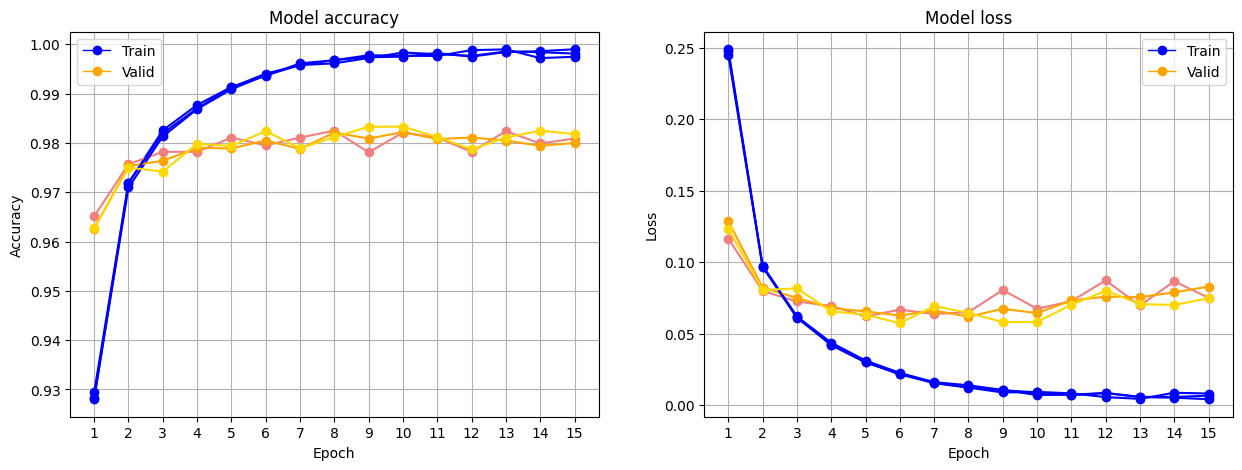

In [18]:
from utils.tools import plot_loss_accuracy

H = []
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_NN()
    
    # train the network
    hist = model.fit(x_train, y_train, epochs=15, batch_size=128, 
                     validation_data=(x_valid, y_valid), verbose=0)
    H.append(hist)

plot_loss_accuracy(H, single_color=False)

training  #1 #2 #3

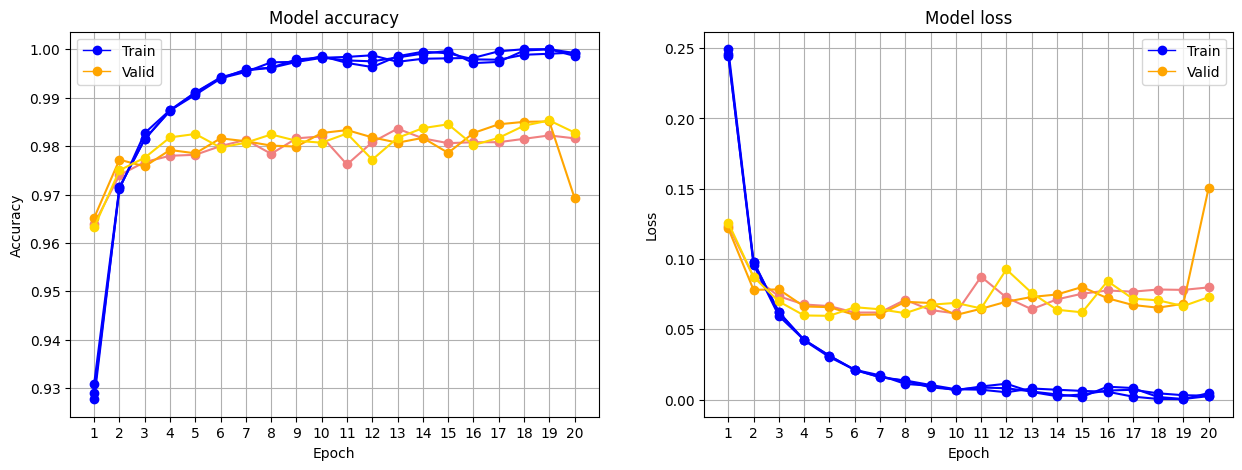

In [19]:
from utils.tools import plot_loss_accuracy

H = []
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_NN()
    
    # train the network
    hist = model.fit(x_train, y_train, epochs=20, batch_size=128, 
                     validation_data=(x_valid, y_valid), verbose=0)
    H.append(hist)

plot_loss_accuracy(H, single_color=False)

The `val_loss` and `val_accuracy` differ at each training.<br>
It can be a problem if we use a _callback_ like __early stoppping__ : the training will stop at a different epoch if we run the training many times.

#### A new network a each time with the seed set:

training  #1 #2 #3

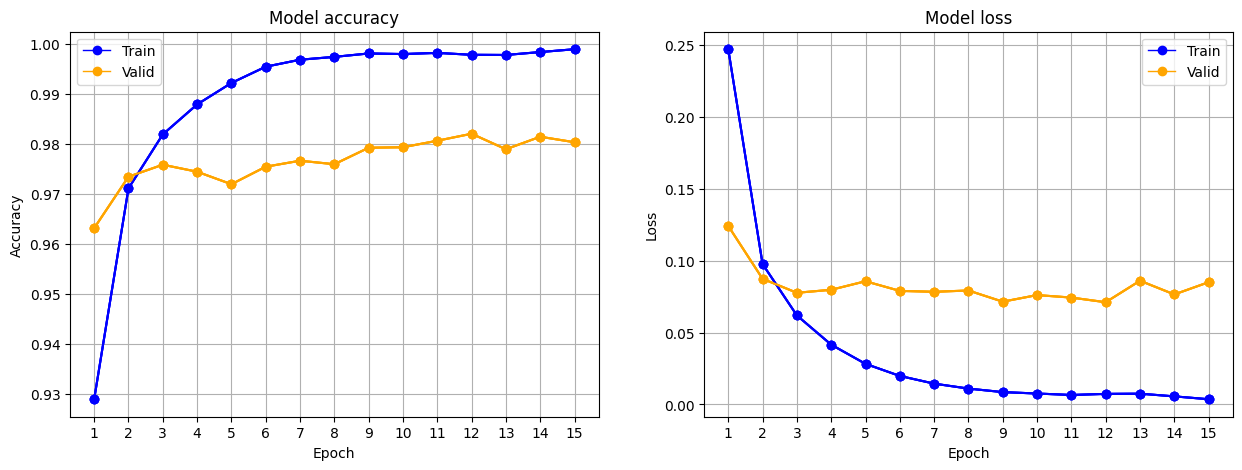

In [20]:
from utils.tools import plot_loss_accuracy

H = []
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_NN(1234)
    
    # set the seed at each turn of the loop:
    #tf.keras.utils.set_random_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, epochs=15, batch_size=128,
                     validation_data=(x_valid, y_valid), verbose=0)
        
    H.append(hist)

plot_loss_accuracy(H)

$\leadsto$ the repoducibility is perfect &#128526;

#### Reload the initial state and set the seed et each time:

training  #1

/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Study-00/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 #2 #3

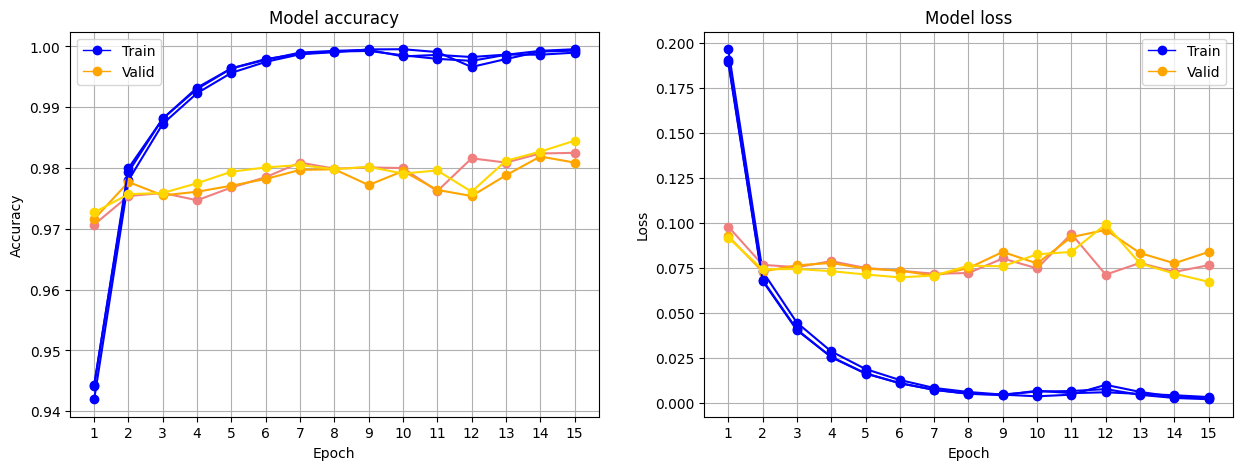

In [21]:
from utils.tools import plot_loss_accuracy

H = []
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # reload the structure of the NN and its initial state 
    model.load_weights('weights/initialNN.weights.h5') 
    
    # set the seed at each turn of the loop:
    tf.keras.utils.set_random_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, epochs=15, batch_size=128,
                     validation_data=(x_valid, y_valid), verbose=0)
    
    H.append(hist)

plot_loss_accuracy(H, single_color=False)

training  #1 #2 #3

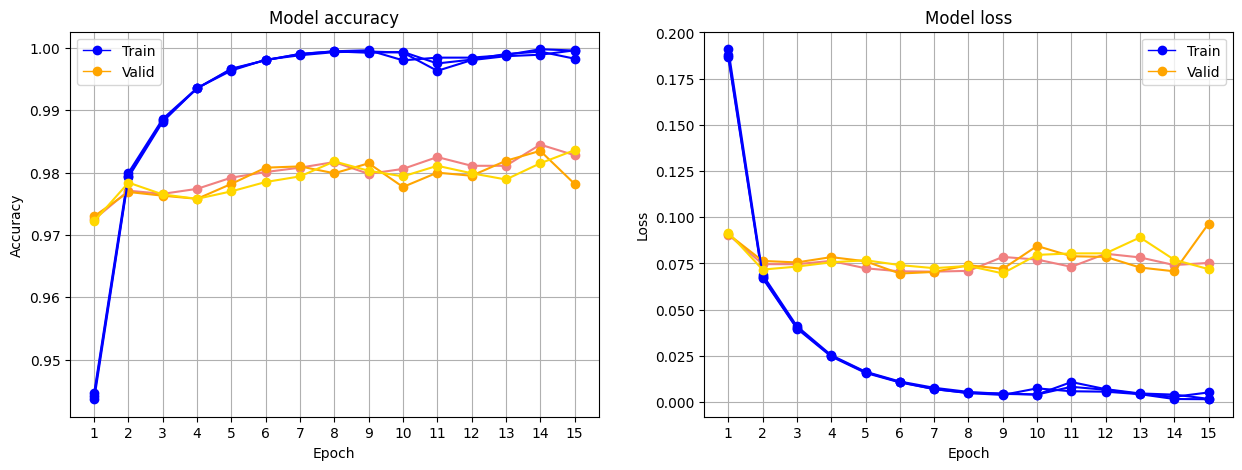

In [22]:
from utils.tools import plot_loss_accuracy

H = []
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # reload the structure of the NN and its initial state 
    model.load_weights('weights/initialNN.weights.h5') 
    
    # set the seed at each turn of the loop:
    tf.keras.utils.set_random_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, epochs=15, batch_size=128,
                     validation_data=(x_valid, y_valid), verbose=0)
    
    H.append(hist)

plot_loss_accuracy(H, single_color=False)

The `val_loss` and `val_accuracy` differ at each training.<br>
It can be a problem if we use a _callback_ like __early stoppping__ : the training will stop at a different epoch if we run the training many times.

#### Reload the entire structure and the initial state of the network and set the seed et each time:

training  #1 #2 #3

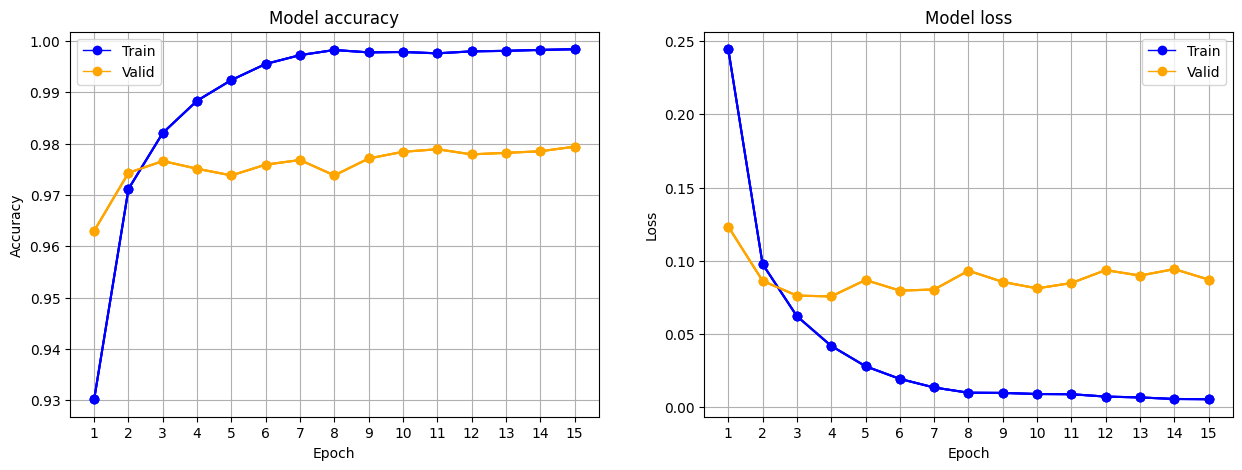

In [23]:
from utils.tools import plot_loss_accuracy

H = []
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # reload the structure of the NN and its initial state 
    model= tf.keras.models.load_model('models/initialNN.keras') 
    
    # set the seed at each turn of the loop:
    tf.random.set_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, epochs=15, batch_size=128,
                     validation_data=(x_valid, y_valid), verbose=0)
    
    #print(f"loss: {hist.history['loss'][-1]:.3f}", end="")
    #print(f", accuracy: {hist.history['accuracy'][-1]:.3f}", end="")    
    #print(f", val_loss: {hist.history['val_loss'][-1]:.3f}", end="")
    #print(f", val_accuracy: {hist.history['val_accuracy'][-1]:.3f}")    
    H.append(hist)

plot_loss_accuracy(H)

Now that the training is reproducible it makes sens to study the influnece of some meta-parameters (n_epoch, batch_size...) on the performance of the trained network.

# Other interesting resources... videos:

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Saving the state of the NN

We can save the __initial random state__ of the weights of the untrained network with the `save_weights` method of the `Sequential` class:

In [59]:
import os

# check if the 'weights' directory exists, otherwise create it:
if not os.path.isdir("weights"): os.mkdir("weights")

#saving the initial values of the NN weights:
weights_file = 'initialNN.weights.h5'
model.save_weights('weights/' + weights_file)

# display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights")]
files.sort()
for f in files: print(f)

weights/initialNN.weights.h5


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">
$\leadsto$ This can be useful to reset the network to its initial state before running new trainings
</spawn>

### Saving the full structure and the weights of the NN

The `save` method of the `Sequential` class allows to save in files **the full structure and the weights** of the NN:

In [60]:
import os

# check if the 'models' directory exists, otherwise create it:
if not os.path.isdir("models"): os.mkdir("models")

# saving the model structure & initial weights:
model_file = 'initialNN.keras'
model.save('models/' + model_file) 

# display the created files:
files=[os.path.join("models",f) for f in os.listdir("models")]
for f in files: print(f)

models/initialNN.keras


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">We can re-create later from scratch the entire network (initial or trained state) with the __tf.keras.models.load_model__ function.
</spawn>